In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Outline

### steps:
1. read in output pandas summary DFs from each constituent pool
  - add a pool / plate column
  - combine
2. read in output plate survey
  - add to combined DF per-plate
3. read in combined read counts
  - merge with DF on sample name (may need to munge sample names)
4. calculate per-nL reads value
5. calculate additional nL necessary to achieve target
6. rank list based on addn'l nL needed
7. find / visualize cutoffs for ???
8. evaluate samples that need to be RE-LIBRARY'd
  - create DNA pick-list, sep by source plate
  - can input into pooling run
9. evaluate samples that can be TOPPED-OFF
  - samples not being re-librarie'd that can be successfully repooled
  - figure out how many total reads --> lane frac --> pooling #s
10. estimate combined pool of new libraries
  - should include fudge factor --> oversequence


### Step 1: Read in output pandas summary DFs from each pool

In [2]:
def read_plate_dfs(plate_dfs):
    lib_df = pd.DataFrame()
    
    for plate in plate_dfs:
        p = pd.read_csv(plate_dfs[plate], sep='\t', index_col=0)
        p['Pool name'] = plate
        lib_df = pd.concat([lib_df, p])
    lib_df = lib_df.rename_axis('Pool Index').reset_index()
        
    return(lib_df)

In [3]:
# list of plates

plate_dfs = {'Finrisk_25-28': './finrisk_data/Finrisk_25-28_dataframe.txt',
             'Finrisk_33-36': './finrisk_data/FinRisk_33-36_data_frame.txt',
             'Finrisk_45-48': './finrisk_data/2017-09-29_FinRisk_45-48_plate_dataframe.txt',
             'Finrisk_53-56': './finrisk_data/Finrisk_53-56_dataframe.txt',
             'Finrisk_69-72': './finrisk_data/Finrisk_69-72_dataframe.txt'}

# read in plates
lib_df = read_plate_dfs(plate_dfs)

In [4]:
lib_df.head()

,Pool Index,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well,...,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume,Pool name
0,0,25-A1,A,1,False,A1,0.075,3500.0,0.0,A1,...,iTru5_plate,iTru7_109_01,CTCGTCTT,A22,iTru7_plate,A1,14.43,4.614360,100.000000,Finrisk_25-28
1,1,820250065-0,C,1,False,C1,0.880,3500.0,0.0,C1,...,iTru5_plate,iTru7_109_02,CGAACTGT,B22,iTru7_plate,C1,8.57,300.463310,69.337362,Finrisk_25-28
2,2,820078521-2,E,1,False,E1,5.334,937.5,2562.5,E1,...,iTru5_plate,iTru7_109_03,CATTCGGT,C22,iTru7_plate,E1,9.59,145.244505,143.436292,Finrisk_25-28
3,3,820228535-4,G,1,False,G1,1.632,3062.5,437.5,G1,...,iTru5_plate,iTru7_109_04,TCGGTTAC,D22,iTru7_plate,G1,9.31,177.321007,117.489370,Finrisk_25-28
4,4,820065961-9,I,1,False,I1,1.068,3500.0,0.0,I1,...,iTru5_plate,iTru7_109_05,AAGTCGAG,E22,iTru7_plate,I1,8.17,399.569315,52.139473,Finrisk_25-28


In [5]:
lib_df.shape

(1920, 26)

### Step 3: read in combined read counts

In [6]:
def read_multiqc_out(fp, regex='^(.+?)\.(R\d)\.trimmed\.filtered\..+$'):
    reads_df = pd.read_csv(fp, sep='\t', header=0)
    
    # extract read and sample name
    reads_df[['Sample','Read']] = reads_df['Sample'].str.extract(regex, expand=True)
    
    return(reads_df)

In [7]:
# read in combined read counts

reads_fp = './finrisk_data/multiqc_fastqc.txt'

reads_df = read_multiqc_out(reads_fp)

reads_df['log10 Total Sequences'] = np.log10(reads_df['Total Sequences'])

In [8]:
reads_df.head()

,Sample,per_sequence_quality_scores,sequence_duplication_levels,per_sequence_gc_content,per_base_sequence_content,%GC,per_base_sequence_quality,overrepresented_sequences,adapter_content,Filename,...,Total Sequences,Sequences flagged as poor quality,sequence_length_distribution,per_tile_sequence_quality,per_base_n_content,total_deduplicated_percentage,Sequence length,Encoding,Read,log10 Total Sequences
0,1-A1,pass,pass,pass,warn,46.0,pass,pass,pass,1-A1.R1.trimmed.filtered.fastq.gz,...,767186.0,0.0,warn,warn,pass,86.474925,100-151,Sanger / Illumina 1.9,R1,5.884901
1,1-A1,pass,pass,pass,warn,46.0,pass,pass,pass,1-A1.R2.trimmed.filtered.fastq.gz,...,767186.0,0.0,warn,warn,pass,88.093452,100-151,Sanger / Illumina 1.9,R2,5.884901
2,1-C12,pass,pass,pass,warn,47.0,pass,pass,pass,1-C12.R1.trimmed.filtered.fastq.gz,...,8556.0,0.0,warn,fail,pass,92.531557,100-151,Sanger / Illumina 1.9,R1,3.932271
3,1-C12,pass,pass,warn,warn,47.0,pass,pass,pass,1-C12.R2.trimmed.filtered.fastq.gz,...,8556.0,0.0,warn,fail,pass,93.595138,100-151,Sanger / Illumina 1.9,R2,3.932271
4,1-F1,pass,pass,pass,warn,46.0,pass,pass,pass,1-F1.R1.trimmed.filtered.fastq.gz,...,66812.0,0.0,warn,warn,pass,89.207029,101-151,Sanger / Illumina 1.9,R1,4.824854


In [9]:
reads_df.shape

(15338, 24)

In [10]:
reads_df.columns

Index(['Sample', 'per_sequence_quality_scores', 'sequence_duplication_levels',
       'per_sequence_gc_content', 'per_base_sequence_content', '%GC',
       'per_base_sequence_quality', 'overrepresented_sequences',
       'adapter_content', 'Filename', 'File type', 'basic_statistics',
       'avg_sequence_length', 'kmer_content', 'Total Sequences',
       'Sequences flagged as poor quality', 'sequence_length_distribution',
       'per_tile_sequence_quality', 'per_base_n_content',
       'total_deduplicated_percentage', 'Sequence length', 'Encoding', 'Read',
       'log10 Total Sequences'],
      dtype='object')

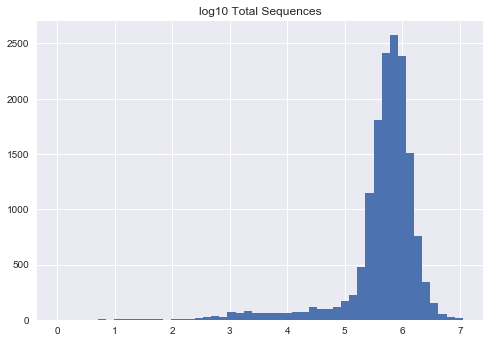

In [11]:
axs = reads_df.hist(column = 'log10 Total Sequences', bins=50)

In [12]:
# Merge with other sample info

total_df = pd.merge(left=lib_df, right=reads_df.loc[reads_df['Read'] == 'R1',], left_on='Sample', right_on='Sample', how='inner')
total_df.head()

,Pool Index,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well,...,Total Sequences,Sequences flagged as poor quality,sequence_length_distribution,per_tile_sequence_quality,per_base_n_content,total_deduplicated_percentage,Sequence length,Encoding,Read,log10 Total Sequences
0,0,25-A1,A,1,False,A1,0.075,3500.0,0.0,A1,...,2256.0,0.0,warn,fail,pass,97.251773,100-151,Sanger / Illumina 1.9,R1,3.353339
1,1,820250065-0,C,1,False,C1,0.880,3500.0,0.0,C1,...,1397430.0,0.0,warn,pass,pass,97.347650,100-151,Sanger / Illumina 1.9,R1,6.145330
2,2,820078521-2,E,1,False,E1,5.334,937.5,2562.5,E1,...,1657841.0,0.0,warn,pass,pass,96.926072,100-151,Sanger / Illumina 1.9,R1,6.219543
3,3,820228535-4,G,1,False,G1,1.632,3062.5,437.5,G1,...,1391876.0,0.0,warn,pass,pass,98.245479,100-151,Sanger / Illumina 1.9,R1,6.143601
4,4,820065961-9,I,1,False,I1,1.068,3500.0,0.0,I1,...,1302778.0,0.0,warn,pass,pass,97.805103,100-151,Sanger / Illumina 1.9,R1,6.114870


In [13]:
# set blank info because it wasn't set in main!

total_df['Blank'] = True
total_df.loc[total_df['Sample'].str.match('\d\d\d\d\d\d\d\d\d+-\d'), 'Blank'] = False

In [14]:
total_df.head()

,Pool Index,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well,...,Total Sequences,Sequences flagged as poor quality,sequence_length_distribution,per_tile_sequence_quality,per_base_n_content,total_deduplicated_percentage,Sequence length,Encoding,Read,log10 Total Sequences
0,0,25-A1,A,1,True,A1,0.075,3500.0,0.0,A1,...,2256.0,0.0,warn,fail,pass,97.251773,100-151,Sanger / Illumina 1.9,R1,3.353339
1,1,820250065-0,C,1,False,C1,0.880,3500.0,0.0,C1,...,1397430.0,0.0,warn,pass,pass,97.347650,100-151,Sanger / Illumina 1.9,R1,6.145330
2,2,820078521-2,E,1,False,E1,5.334,937.5,2562.5,E1,...,1657841.0,0.0,warn,pass,pass,96.926072,100-151,Sanger / Illumina 1.9,R1,6.219543
3,3,820228535-4,G,1,False,G1,1.632,3062.5,437.5,G1,...,1391876.0,0.0,warn,pass,pass,98.245479,100-151,Sanger / Illumina 1.9,R1,6.143601
4,4,820065961-9,I,1,False,I1,1.068,3500.0,0.0,I1,...,1302778.0,0.0,warn,pass,pass,97.805103,100-151,Sanger / Illumina 1.9,R1,6.114870


### Step 4: calculate per-nL reads value

In [15]:
total_df.columns

Index(['Pool Index', 'Sample', 'Row', 'Col', 'Blank', 'Well',
       'Sample DNA Concentration', 'Normalized DNA volume',
       'Normalized water volume', 'Library Well', 'index', 'index combo',
       'index combo seq', 'i5 name', 'i5 sequence', 'i5 well', 'i5 plate',
       'i7 name', 'i7 sequence', 'i7 well', 'i7 plate', 'Pos', 'Cp',
       'Library Concentration', 'Pooled Volume', 'Pool name',
       'per_sequence_quality_scores', 'sequence_duplication_levels',
       'per_sequence_gc_content', 'per_base_sequence_content', '%GC',
       'per_base_sequence_quality', 'overrepresented_sequences',
       'adapter_content', 'Filename', 'File type', 'basic_statistics',
       'avg_sequence_length', 'kmer_content', 'Total Sequences',
       'Sequences flagged as poor quality', 'sequence_length_distribution',
       'per_tile_sequence_quality', 'per_base_n_content',
       'total_deduplicated_percentage', 'Sequence length', 'Encoding', 'Read',
       'log10 Total Sequences'],
      dtype=

In [16]:
total_df['Sequences per nL'] = total_df['Total Sequences'] / total_df['Pooled Volume']

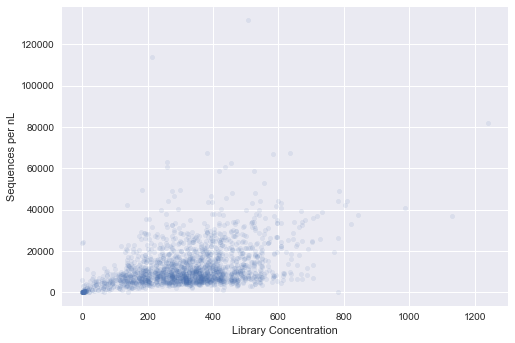

In [17]:
ax = total_df.plot.scatter(x = 'Library Concentration', y = 'Sequences per nL', alpha=0.1)

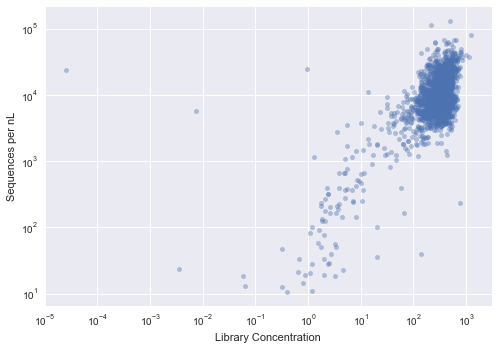

In [18]:
ax = total_df.plot.scatter(x = 'Library Concentration', y = 'Sequences per nL', alpha=0.4, logy=True, logx=True)

### Step 5: calculate additional nL necessary to achieve target

In [19]:
#set target number of sequences

target = 500000

# Create column of differences from target
total_df['Seqs below target'] = target - total_df['Total Sequences']

# Blanks don't have a target, set them to NaN
total_df.loc[total_df['Blank'], 'Seqs below target'] = np.nan

total_df.head()

,Pool Index,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well,...,sequence_length_distribution,per_tile_sequence_quality,per_base_n_content,total_deduplicated_percentage,Sequence length,Encoding,Read,log10 Total Sequences,Sequences per nL,Seqs below target
0,0,25-A1,A,1,True,A1,0.075,3500.0,0.0,A1,...,warn,fail,pass,97.251773,100-151,Sanger / Illumina 1.9,R1,3.353339,22.560000,NaN
1,1,820250065-0,C,1,False,C1,0.880,3500.0,0.0,C1,...,warn,pass,pass,97.347650,100-151,Sanger / Illumina 1.9,R1,6.145330,20154.069306,-897430.0
2,2,820078521-2,E,1,False,E1,5.334,937.5,2562.5,E1,...,warn,pass,pass,96.926072,100-151,Sanger / Illumina 1.9,R1,6.219543,11558.030199,-1157841.0
3,3,820228535-4,G,1,False,G1,1.632,3062.5,437.5,G1,...,warn,pass,pass,98.245479,100-151,Sanger / Illumina 1.9,R1,6.143601,11846.824967,-891876.0
4,4,820065961-9,I,1,False,I1,1.068,3500.0,0.0,I1,...,warn,pass,pass,97.805103,100-151,Sanger / Illumina 1.9,R1,6.114870,24986.405407,-802778.0


### Step 6: rank list based on addn'l nL needed

In [20]:
# Figuring you have X seqs per nL on previous run, divide target # seqs by seqs per nL to get requisite # of nLs
total_df['nL to target'] = total_df['Seqs below target'] / total_df['Sequences per nL']

# create a new sub-df containing the ranked list of samples that need sequences
low_libs = total_df.loc[total_df['nL to target'] > 0,].sort_values(by='nL to target', ascending=False)
low_libs.head()

,Pool Index,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,Library Well,...,per_tile_sequence_quality,per_base_n_content,total_deduplicated_percentage,Sequence length,Encoding,Read,log10 Total Sequences,Sequences per nL,Seqs below target,nL to target
199,199,820210001-8,P,1,False,P1,2.084,2400.0,1100.0,P1,...,fail,pass,99.907063,100-151,Sanger / Illumina 1.9,R1,3.031812,10.76,498924.0,46368.401487
187,187,820234801-3,G,24,False,G24,0.318,3500.0,0.0,G24,...,fail,pass,98.228043,101-151,Sanger / Illumina 1.9,R1,3.113275,12.98,498702.0,38420.801233
367,367,820215945-4,P,20,False,P20,0.752,3500.0,0.0,P20,...,pass,pass,99.447132,100-151,Sanger / Illumina 1.9,R1,3.160469,14.47,498553.0,34454.250173
327,327,820056441-7,P,10,False,P10,0.416,3500.0,0.0,P10,...,fail,pass,98.607777,100-151,Sanger / Illumina 1.9,R1,3.318689,20.83,497917.0,23903.840614
1591,55,820023033-7,O,13,False,O13,1.960,2550.0,950.0,O13,...,fail,pass,97.939030,100-151,Sanger / Illumina 1.9,R1,3.367169,23.29,497671.0,21368.441391


### Step 7: find / visualize cutoffs for ???

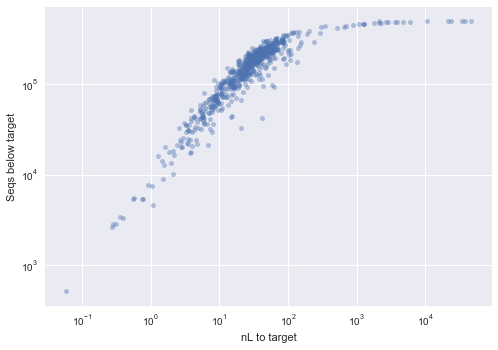

In [21]:
# plot the nL to target against to the # seqs remaining. 

low_libs.plot.scatter(x = 'nL to target', y = 'Seqs below target', logx=True, logy=True, alpha=0.4)

Here, we can see that the vast majority of samples below target need ≤ 100 nL of additional library sequenced (given proportional representation on a complete lane equivalent)

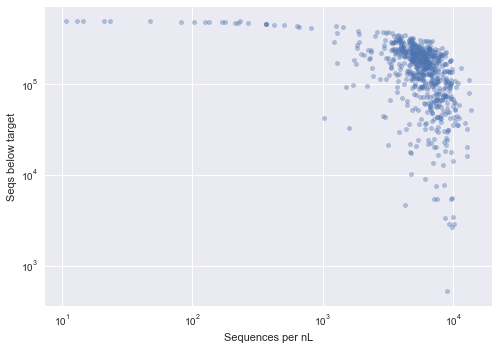

In [22]:
low_libs.plot.scatter(x = 'Sequences per nL', y = 'Seqs below target', logx=True, logy=True, alpha=0.4)

This shows the tail of samples that had very poor concentrations---failed libraries. 

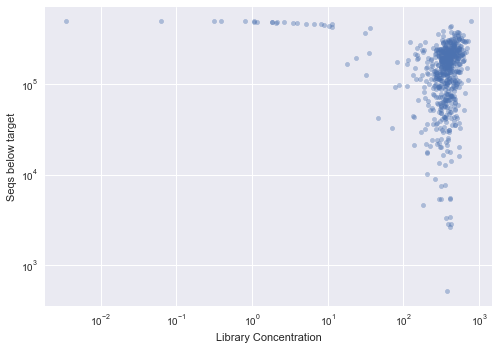

In [23]:
low_libs.plot.scatter(x = 'Library Concentration', y = 'Seqs below target', logx=True, logy=True, alpha=0.4)

Further demonstrating the tail of failed samples also generally showed low concentration estimates with the qPCR assay. 

### Step 8: evaluate samples that need to be RE-LIBRARY'd

Figuring we can either:
1. remake 'worst' N libraries; combining failures and non-failures
2. remake only libraries below a threshold concentration

In [24]:
# Option 1: worst N libs

max_libs = 90

remake_libs_1 = low_libs.sort_values(by='Sequences per nL', ascending=True).iloc[0:max_libs,]
remake_libs_1.shape[0]

90

In [25]:
# Option 2: only failed libs

remake_libs_2 = low_libs.loc[low_libs['Sequences per nL'] < 1000,]
remake_libs_2.shape[0]

24

In [26]:
# barcode collisions among complete low-lib set

len(low_libs['index combo seq']) - len(set(low_libs['index combo seq']))

63

In [27]:
low_libs.shape[0]

630

In [28]:
# Grabbing # of post-QC seqs per lane to get an idea of what proportion of a flow cell this amounts to:

mean_seqs_per_lane = total_df.groupby(['Pool name']).sum()['Total Sequences'].mean()

low_libs['Seqs below target'].sum() / mean_seqs_per_lane

0.33746162736181579

### Step 9: evaluate samples that can be TOPPED-OFF

### Step 10: estimate combined pool of new libraries